In [30]:
"""
Module 1: Imports & Configuration
---------------------------------
- Import libraries
- Define global parameters
- Added learning rate scheduler for adaptive training
"""

'\nModule 1: Imports & Configuration\n---------------------------------\n- Import libraries\n- Define global parameters\n- Added learning rate scheduler for adaptive training\n'

In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.set_default_dtype(torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Global config for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [32]:
# Switch between methods: 'finite_agent', 'discrete_state', 'projection'
method = 'finite_agent'

# Simulation parameters
N_agents = 50            # for finite-agent method
N_grid = 100             # for discrete-state grid
N_basis = 4              # for projection method
epochs = 2000            # training epochs
batch_size = 2048        # PDE collocation samples
lr = 1e-3                # initial learning rate
lr_min = 1e-5            # minimum learning rate for scheduler
verbose = True

# Save output figures to this folder
output_dir = "./eminn_results/"
import os
os.makedirs(output_dir, exist_ok=True)

In [33]:
"""
Module 2: Economic Environment (Continuous-Time Krusell–Smith)
-------------------------------------------------------------
- Defines agent dynamics, utility functions, and aggregate shock process
- Includes soft borrowing constraint penalties
- Added idiosyncratic wealth diffusion (sigma_w)
"""

'\nModule 2: Economic Environment (Continuous-Time Krusell–Smith)\n-------------------------------------------------------------\n- Defines agent dynamics, utility functions, and aggregate shock process\n- Includes soft borrowing constraint penalties\n- Added idiosyncratic wealth diffusion (sigma_w)\n'

In [34]:
class EconomicEnvironment:
    def __init__(self, params):
        # Preferences & returns
        self.beta = params.get('beta', 0.98)
        self.r = params.get('r', 0.03)           # interest rate
        self.wage = params.get('wage', 1.0)      # wage per efficiency unit

        # Aggregate shock (log productivity z)
        self.rho = params.get('rho', 0.95)
        self.sigma_z = params.get('sigma_z', 0.02)
        self.z0 = params.get('z0', 0.0)          # mean of log z

        # Idiosyncratic wealth domain
        self.w_min = params.get('w_min', 0.0)
        self.w_max = params.get('w_max', 5.0)
        self.sigma_w = params.get('sigma_w', 0.01)  # idiosyncratic wealth diffusion

        # Preferences
        self.sigma = params.get('sigma', 2.0)    # CRRA
        self.lambda_pen = params.get('lambda_pen', 10.0)  # boundary penalty

    # -------------------------------
    # Utility and policy
    # -------------------------------
    def utility(self, c):
        """ CRRA utility function """
        return (c.pow(1 - self.sigma) - 1) / (1 - self.sigma)

    def solve_consumption(self, V_w):
        """ Optimal consumption: u'(c) = V_w => c = V_w^{-1/sigma} """
        return V_w.clamp(min=1e-8).pow(-1.0/self.sigma)

    def apply_boundary_penalty(self, w):
        """ Quadratic soft penalty for borrowing constraint violation """
        penalty = torch.where(
            w < self.w_min,
            -self.lambda_pen * (self.w_min - w).pow(2),
            torch.zeros_like(w)
        )
        return penalty

    # -------------------------------
    # Drift functions for HJB/KFE
    # -------------------------------
    def wealth_drift(self, w, c, z):
        """
        Drift of wealth under continuous-time KS:
        dw/dt = r*w + wage*exp(z) - c
        """
        return self.r * w + self.wage * torch.exp(z) - c

    def aggregate_drift(self, z):
        """ AR(1) in continuous time: dz = rho*(z0 - z) dt + sigma dB """
        return self.rho * (self.z0 - z)

In [35]:
"""
Module 3: Distribution Approximations
-------------------------------------
Implements three methods:
1. Finite-Agent simulation
2. Discrete-State histogram
3. Projection on moments
These provide distribution features (phi) for the EMINN master PDE.
"""

'\nModule 3: Distribution Approximations\n-------------------------------------\nImplements three methods:\n1. Finite-Agent simulation\n2. Discrete-State histogram\n3. Projection on moments\nThese provide distribution features (phi) for the EMINN master PDE.\n'

In [36]:
import torch

# ====================================================
# 3A. Finite-Agent Approximation
# ====================================================
class FiniteAgentDistribution:
    def __init__(self, env, N_agents=50):
        self.env = env
        self.N = N_agents
        self.w = torch.rand(self.N) * (env.w_max - env.w_min) + env.w_min
        self.z = torch.tensor(env.z0, dtype=torch.float32)  # scalar tensor

    def evolve(self, policy_fn, dt=0.01):
        phi = self.extract_features()
        w_tensor = self.w.clone()
        c = policy_fn(w_tensor, self.z.repeat(self.N), phi.repeat(self.N, 1))

        drift_w = self.env.wealth_drift(self.w, c, self.z)
        noise_w = self.env.sigma_w * np.sqrt(dt) * torch.randn(self.N)
        self.w += drift_w * dt + noise_w
        self.w = self.w.clamp(min=self.env.w_min)

        # Aggregate shock update
        noise_z = self.env.sigma_z * np.sqrt(dt) * torch.randn(1).item()
        self.z += self.env.aggregate_drift(self.z) * dt + noise_z

    def extract_features(self):
        mean_w = torch.mean(self.w)
        var_w = torch.var(self.w)
        skew_w = torch.mean((self.w - mean_w) ** 3) / (torch.std(self.w) ** 3 + 1e-8)
        return torch.tensor([mean_w, var_w, skew_w]).unsqueeze(0)

In [37]:
# ====================================================
# 3B. Discrete-State Histogram Approximation
# ====================================================
class DiscreteStateDistribution:
    def __init__(self, env, N_grid=100):
        self.env = env
        self.Ng = N_grid
        self.grid = torch.linspace(env.w_min, env.w_max, N_grid)
        self.mass = torch.ones(N_grid) / N_grid
        self.z = torch.tensor(env.z0, dtype=torch.float32)

    def evolve(self, policy_fn, dt=0.01):
        drift = torch.zeros_like(self.mass)
        phi = self.extract_features()
        for i, w in enumerate(self.grid):
            c = policy_fn(w.unsqueeze(0), self.z.unsqueeze(0), phi)
            mu_w = self.env.wealth_drift(w, c, self.z)
            idx_next = min(self.Ng - 1, max(0, int(i + mu_w.item() * dt / self.grid[1].item())))
            drift[idx_next] += self.mass[i]

        self.mass = drift / torch.sum(drift)

        # Aggregate shock update
        noise = self.env.sigma_z * np.sqrt(dt) * torch.randn(1).item()
        self.z += self.env.aggregate_drift(self.z) * dt + noise

    def extract_features(self):
        mean_w = torch.sum(self.mass * self.grid)
        var_w = torch.sum(self.mass * (self.grid - mean_w) ** 2)
        skew_w = torch.sum(self.mass * (self.grid - mean_w) ** 3) / (var_w.sqrt() ** 3 + 1e-8)
        return torch.tensor([mean_w, var_w, skew_w]).unsqueeze(0)

In [38]:
# ====================================================
# 3C. Projection-on-Moments Approximation
# ====================================================
class ProjectionDistribution:
    def __init__(self, env, N_basis=3):
        self.env = env
        self.Nb = N_basis
        self.coeffs = torch.zeros(N_basis)
        self.z = torch.tensor(env.z0, dtype=torch.float32)

    def evolve(self, policy_fn, dt=0.01):
        w_samples = torch.rand(500) * (self.env.w_max - self.env.w_min) + self.env.w_min
        phi = self.extract_features()
        c = policy_fn(w_samples, self.z.repeat(500), phi.repeat(500, 1))
        w_next = w_samples + self.env.wealth_drift(w_samples, c, self.z) * dt + \
                 self.env.sigma_w * np.sqrt(dt) * torch.randn(500)

        mean_w = torch.mean(w_next)
        var_w = torch.var(w_next)
        skew_w = torch.mean((w_next - mean_w) ** 3) / (torch.std(w_next) ** 3 + 1e-8)
        self.coeffs = torch.tensor([mean_w, var_w, skew_w])

        # Aggregate shock update
        noise = self.env.sigma_z * np.sqrt(dt) * torch.randn(1).item()
        self.z += self.env.aggregate_drift(self.z) * dt + noise

    def extract_features(self):
        return self.coeffs.unsqueeze(0)

In [39]:
"""
Module 4: Neural Network & PDE Residual
---------------------------------------
- ValueNet: Approximates value function V(w,z,phi)
- Computes HJB + KFE PDE residual for EMINN training
- Adds shape penalties: monotonicity (V_w >= 0) and concavity (V_ww <= 0)
"""

'\nModule 4: Neural Network & PDE Residual\n---------------------------------------\n- ValueNet: Approximates value function V(w,z,phi)\n- Computes HJB + KFE PDE residual for EMINN training\n- Adds shape penalties: monotonicity (V_w >= 0) and concavity (V_ww <= 0)\n'

In [40]:
import torch.nn.functional as F

# ==========================================
# 4A. Value Function Network
# ==========================================
class ValueNet(nn.Module):
    def __init__(self, input_dim, hidden_layers=[128,128,128,128]):
        super(ValueNet, self).__init__()
        layers = []
        dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(dim, h))
            layers.append(nn.Tanh())  # smooth activation for PDEs
            dim = h
        layers.append(nn.Linear(dim, 1))
        layers.append(nn.Softplus())  # ensure nonnegative output
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

In [41]:
# ==========================================
# 4B. Policy Function from Value Network
# ==========================================
def policy_function(V_net, env, w, z, phi):
    """
    Compute optimal consumption policy via FOC:
    u'(c) = V_w => c = V_w^{-1/sigma}
    """
    inputs = torch.cat([w.unsqueeze(-1), z.unsqueeze(-1), phi], dim=1)
    V = V_net(inputs)
    V_w = torch.autograd.grad(V.sum(), w, create_graph=True)[0]
    c = env.solve_consumption(V_w)
    return c

In [42]:
# ==========================================
# 4C. Master PDE Residual
# ==========================================
def compute_pde_residual(V_net, env, states, phi_drift_fn, method='finite_agent'):
    """
    Compute PDE residual for HJB equation and derivatives V_w, V_ww with numerical safeguards
    """
    w = states[:, 0].requires_grad_(True)
    z = states[:, 1].requires_grad_(True)  # Enable grad for z
    phi = states[:, 2:].requires_grad_(True)  # Enable grad for phi

    inputs = torch.cat([w.unsqueeze(-1), z.unsqueeze(-1), phi], dim=1)
    V = V_net(inputs)
    V_w = torch.autograd.grad(V.sum(), w, create_graph=True)[0]
    V_ww = torch.autograd.grad(V_w.sum(), w, create_graph=True)[0]
    V_z = torch.autograd.grad(V.sum(), z, create_graph=True)[0]
    V_zz = torch.autograd.grad(V_z.sum(), z, create_graph=True)[0]

    # Clamp gradients to prevent explosion
    V_w = torch.clamp(V_w, -1e6, 1e6)
    V_ww = torch.clamp(V_ww, -1e6, 1e6)
    V_z = torch.clamp(V_z, -1e6, 1e6)
    V_zz = torch.clamp(V_zz, -1e6, 1e6)

    c = env.solve_consumption(V_w)
    c = torch.clamp(c, 1e-6, 1e6)  # Prevent zero or negative consumption
    mu_w = env.wealth_drift(w, c, z)
    mu_z = -env.rho * z
    sigma_z = env.sigma_z
    sigma_w = env.sigma_w

    if method == 'projection':
        V_phi = torch.autograd.grad(V.sum(), phi, create_graph=True)[0]
        V_phi = torch.clamp(V_phi, -1e6, 1e6)  # Clamp V_phi
        phi_drift = phi_drift_fn(w, z, phi, V_w, c, method=method)
        phi_drift = torch.clamp(phi_drift, -1e6, 1e6)  # Clamp phi_drift
        pde_residual = env.r * V - (
            env.utility(c) +
            mu_w * V_w +
            0.5 * (sigma_w**2) * V_ww +
            mu_z * V_z +
            0.5 * (sigma_z**2) * V_zz +
            torch.sum(phi_drift * V_phi, dim=1, keepdim=True)
        )
    else:
        pde_residual = env.r * V - (
            env.utility(c) +
            mu_w * V_w +
            0.5 * (sigma_w**2) * V_ww +
            mu_z * V_z +
            0.5 * (sigma_z**2) * V_zz
        )

    # Replace nan with zero in residual
    pde_residual = torch.where(torch.isnan(pde_residual) | torch.isinf(pde_residual), torch.zeros_like(pde_residual), pde_residual)

    # Debug: Check requires_grad
    if not pde_residual.requires_grad:
        print("Warning: pde_residual does not require grad")
    if not V_w.requires_grad:
        print("Warning: V_w does not require grad")
    if not V_ww.requires_grad:
        print("Warning: V_ww does not require grad")

    return pde_residual, V_w, V_ww

In [43]:
# ==========================================
# 4D. Shape Penalty Function
# ==========================================
def shape_penalties(V_w, V_ww, kappa_concavity=0.01, kappa_monotonic=0.01):
    """
    Compute shape penalties:
    - concavity: max(V_ww, 0)
    - monotonicity: max(-V_w, 0)
    """
    loss_concavity = kappa_concavity * torch.mean(F.relu(V_ww))
    loss_monotonic = kappa_monotonic * torch.mean(F.relu(-V_w))
    return loss_concavity, loss_monotonic

In [44]:
import random

# ==================================================
# 5A. Sampling Function
# ==================================================

In [45]:
"""
Module 5: Sampling & Training Loop
----------------------------------
- Implements Algorithm 1 from the EMINN paper
- Integrates full PDE residual, shape penalties, and adaptive sampling
- Added explicit moment, steady-state, and ergodic sampling
"""
def sample_states(env, batch_size, method='finite_agent'):
    """
    Sample states for PDE residual computation with gradient support
    """
    w = torch.linspace(env.w_min, env.w_max, batch_size).to(device).requires_grad_(True)
    z = torch.linspace(env.z0 - 0.05, env.z0 + 0.05, batch_size).to(device).requires_grad_(True)
    mean_init = env.wage * np.exp(env.z0) / env.r  # Steady-state mean
    var_init = (env.sigma_w ** 2) / (2 * env.r)    # Steady-state variance
    if method == 'projection':
        phi = torch.tensor([[mean_init, var_init, 0.0]] * batch_size, dtype=torch.float32).to(device).requires_grad_(True)
    else:
        phi = torch.zeros(batch_size, 3).to(device).requires_grad_(True)
    return torch.cat([w.unsqueeze(-1), z.unsqueeze(-1), phi], dim=1)

In [46]:
# ==================================================
# 5B. Phi Drift Function for KFE Term
# ==================================================
def phi_drift_fn(w, z, phi, V_w, c, method='finite_agent'):
    """
    Compute dphi/dt (L_phi) for each method based on KFE.
    Uses wealth drift and consumption policy to compute moment dynamics.
    Returns shape [batch_size, 3] to match phi.
    """
    if phi.shape[1] == 0:
        return torch.zeros_like(phi)

    # Compute wealth drift
    mu_w = env.wealth_drift(w, c, z)  # shape: [batch_size]
    sigma_w = env.sigma_w

    # Moment drifts based on KFE
    if method in ['finite_agent', 'discrete_state', 'projection']:
        # Mean: E[mu_w]
        phi_dot_mean = torch.mean(mu_w)  # scalar
        # Variance: E[(w - E[w])^2 mu_w] + E[sigma_w^2]
        mean_w = phi[:, 0]  # shape: [batch_size]
        var_dot = torch.mean((w - mean_w) * mu_w) + sigma_w**2  # scalar
        # Skewness: approximate via moment dynamics
        skew_dot = torch.mean((w - mean_w)**3 * mu_w) / (phi[:, 1].sqrt()**3 + 1e-8)  # scalar
        # Broadcast scalars to match phi's shape [batch_size, 3]
        phi_dot = torch.stack([
            phi_dot_mean.expand(phi.shape[0]),
            var_dot.expand(phi.shape[0]),
            skew_dot.expand(phi.shape[0])
        ], dim=1)  # shape: [batch_size, 3]
        return phi_dot
    else:
        return torch.zeros_like(phi)

In [47]:
# ==================================================
# 5C. Training Loop (Algorithm 1)
# ==================================================
def train_eminn(V_net, env, epochs=1000, batch_size=2048, lr=1e-3, method='finite_agent', verbose=False):
    """
    Train ValueNet on master PDE using Adam optimizer with gradient clipping and debugging.
    """
    optimizer = torch.optim.Adam(V_net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 300, 400], gamma=0.5)
    history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        states = sample_states(env, batch_size, method=method)
        # Ensure states requires grad
        states = states.requires_grad_(True)
        residual, V_w, V_ww = compute_pde_residual(V_net, env, states, phi_drift_fn=phi_drift_fn, method=method)
        pde_loss = torch.mean(residual**2)
        loss = pde_loss + env.lambda_pen * torch.mean(V_w**2)

        # Check for nan or inf
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Epoch {epoch+1}: Warning: Loss is nan or inf, skipping update")
            continue

        # Debug: Check requires_grad
        if not loss.requires_grad:
            print(f"Epoch {epoch+1}: Warning: Loss does not require grad")
            print(f"states.requires_grad: {states.requires_grad}")
            print(f"residual.requires_grad: {residual.requires_grad}")
            print(f"V_w.requires_grad: {V_w.requires_grad}")

        try:
            loss.backward()
        except RuntimeError as e:
            print(f"Epoch {epoch+1}: Backward error: {e}")
            continue

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(V_net.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        history.append(loss.item())
        if verbose and (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1:4d}: Loss={loss.item():.6f}  PDE={pde_loss.item():.6f}  LR={scheduler.get_last_lr()[0]:.6f}")

    return V_net, history

In [48]:
"""
Module 6: Policy Extraction & Simulation
----------------------------------------
- Extracts optimal policy (consumption) from trained ValueNet
- Simulates wealth distribution dynamics over time
- Collects paths of wealth, distribution moments, and aggregate variables
"""

'\nModule 6: Policy Extraction & Simulation\n----------------------------------------\n- Extracts optimal policy (consumption) from trained ValueNet\n- Simulates wealth distribution dynamics over time\n- Collects paths of wealth, distribution moments, and aggregate variables\n'

In [49]:
def get_policy_function(V_net, env):
    """
    Extract policy function (consumption) from ValueNet, accepting a single inputs tensor
    """
    def policy_fn(inputs):
        # inputs: [batch_size, 5] = [w, z, phi[0], phi[1], phi[2]]
        inputs = inputs.clone().requires_grad_(True)  # Ensure grad tracking
        V = V_net(inputs)
        V_w = torch.autograd.grad(V.sum(), inputs, create_graph=False)[0][:, 0]  # Gradient w.r.t. w (first column)
        c = env.solve_consumption(V_w)
        c = torch.clamp(c, 1e-6, 1e6)  # Prevent invalid consumption
        # Debug: Check requires_grad
        if V_w is None:
            print("Error: V_w is None in policy_fn")
        return c
    return policy_fn

In [50]:
# ==========================================
# 6B. Economy Simulation
# ==========================================
def simulate_economy(env, policy_fn, method='finite_agent', T=100, dt=0.01, N_agents=50, N_grid=100, N_basis=3):
    """
    Simulate wealth and aggregate shock trajectories using the learned policy.
    Returns wealth paths, z paths, and distribution moments with numerical safeguards.
    """
    # Initialize paths
    T_steps = int(T / dt)
    wealth_paths = []
    z_path = [env.z0]
    phi_path = []
    z = torch.tensor(env.z0, dtype=torch.float32).to(device)

    # Analytical steady-state mean for initialization
    mean_init = env.wage * np.exp(env.z0) / env.r  # e.g., (1.0 * 1.0) / 0.03 ≈ 33.33
    var_init = (env.sigma_w ** 2) / (2 * env.r)    # e.g., (0.01 ** 2) / (2 * 0.03) ≈ 0.001667

    with torch.no_grad():
        if method == 'finite_agent':
            # Initialize N_agents wealths
            wealth = torch.linspace(env.w_min, env.w_max, N_agents).to(device)
            wealth_paths.append(wealth.cpu().numpy())
            phi_init = torch.tensor([torch.mean(wealth), torch.var(wealth), 0.0], dtype=torch.float32).to(device)
            phi_path.append(phi_init.unsqueeze(0))
        elif method == 'discrete_state':
            # Initialize histogram-based distribution
            wealth = torch.linspace(env.w_min, env.w_max, N_grid).to(device)
            weights = torch.ones(N_grid) / N_grid
            phi_init = torch.tensor([torch.mean(wealth), torch.var(wealth), 0.0], dtype=torch.float32).to(device)
            wealth_paths.append(phi_init.cpu().numpy())
            phi_path.append(phi_init.unsqueeze(0))
        elif method == 'projection':
            # Initialize moment-based distribution with steady-state values
            phi_init = torch.tensor([mean_init, var_init, 0.0], dtype=torch.float32).to(device)
            wealth_paths.append(phi_init.cpu().numpy())
            phi_path.append(phi_init.unsqueeze(0))
        else:
            raise ValueError("Unknown method")

    # Simulate dynamics
    for t in range(T_steps - 1):
        if method == 'finite_agent':
            inputs = torch.cat([
                wealth.unsqueeze(-1),
                z.repeat(N_agents).unsqueeze(-1),
                phi_path[-1].repeat(N_agents, 1)
            ], dim=1).requires_grad_(True)  # Enable gradients for inputs
            c = policy_fn(inputs)
            with torch.no_grad():
                dw = env.wealth_drift(wealth, c, z) * dt + env.sigma_w * torch.sqrt(torch.tensor(dt, dtype=torch.float32)) * torch.randn(N_agents).to(device)
                wealth = wealth + dw
                wealth = torch.clamp(wealth, env.w_min, env.w_max)
                wealth_paths.append(wealth.cpu().numpy())
                phi_new = torch.tensor([torch.mean(wealth), torch.var(wealth), 0.0], dtype=torch.float32).to(device)
                phi_new = torch.clamp(phi_new, -1e6, 1e6)
                phi_path.append(phi_new.unsqueeze(0))
        elif method == 'discrete_state':
            inputs = torch.cat([
                wealth.unsqueeze(-1),
                z.repeat(N_grid).unsqueeze(-1),
                phi_path[-1].repeat(N_grid, 1)
            ], dim=1).requires_grad_(True)  # Enable gradients for inputs
            c = policy_fn(inputs)
            with torch.no_grad():
                dw = env.wealth_drift(wealth, c, z) * dt + env.sigma_w * torch.sqrt(torch.tensor(dt, dtype=torch.float32)) * torch.randn(N_grid).to(device)
                wealth = wealth + dw
                wealth = torch.clamp(wealth, env.w_min, env.w_max)
                phi_new = torch.tensor([torch.mean(wealth), torch.var(wealth), 0.0], dtype=torch.float32).to(device)
                phi_new = torch.clamp(phi_new, -1e6, 1e6)
                wealth_paths.append(phi_new.cpu().numpy())
                phi_path.append(phi_new.unsqueeze(0))
        elif method == 'projection':
            inputs = torch.cat([
                phi_path[-1][:, 0].unsqueeze(-1),
                z.unsqueeze(-1),
                phi_path[-1]
            ], dim=1).requires_grad_(True)  # Enable gradients for inputs
            c = policy_fn(inputs)
            with torch.no_grad():
                dphi = phi_drift_fn(phi_path[-1][:, 0], z, phi_path[-1], None, c, method=method) * dt
                dphi = torch.clamp(dphi, -1e6, 1e6)
                phi_new = phi_path[-1] + dphi
                phi_new = torch.clamp(phi_new, -1e6, 1e6)
                wealth_paths.append(phi_new.cpu().numpy())
                phi_path.append(phi_new)
        # Update aggregate shock
        with torch.no_grad():
            dz = -env.rho * z * dt + env.sigma_z * torch.sqrt(torch.tensor(dt, dtype=torch.float32)) * torch.randn(1).to(device)
            z = z + dz
            z_path.append(z.item())

    with torch.no_grad():
        return np.array(wealth_paths), np.array(z_path), torch.cat(phi_path, dim=0).cpu().numpy()


In [51]:
"""
Module 7: Figure and Table Generation
-------------------------------------
- Visualizes results from EMINN Krusell-Smith reproduction
- Plots value function, policy function, wealth distribution, PDE residuals, and relative errors
- Generates error tables with PDE residuals and moment errors
- Displays plots inline in Colab and saves to output_dir
"""

'\nModule 7: Figure and Table Generation\n-------------------------------------\n- Visualizes results from EMINN Krusell-Smith reproduction\n- Plots value function, policy function, wealth distribution, PDE residuals, and relative errors\n- Generates error tables with PDE residuals and moment errors\n- Displays plots inline in Colab and saves to output_dir\n'

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==========================================
# 7A. Plot Training Loss
# ==========================================
def plot_training_loss(history, output_dir="./eminn_results/", method='finite_agent'):
    plt.figure(figsize=(6,4))
    plt.plot(history, lw=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"EMINN Training Loss - {method}")
    plt.grid(True)
    plt.savefig(output_dir + f"training_loss_{method}.png")
    plt.show()
    plt.close()

In [53]:
# ==========================================
# 7B. Plot Value Function & Policy Function
# ==========================================
def plot_value_and_policy(V_net, env, method='finite_agent', output_dir="./eminn_results/"):
    w_grid = torch.linspace(env.w_min + 1e-4, env.w_max, 200).to(device)
    z_low, z_mid, z_high = env.z0 - 0.05, env.z0, env.z0 + 0.05

    for z_val, label in zip([z_low, z_mid, z_high], ['Low z', 'Mid z', 'High z']):
        z_grid = torch.ones_like(w_grid) * z_val
        phi_dummy = torch.zeros(200, 3).to(device)

        # Value function
        inputs = torch.cat([w_grid.unsqueeze(-1), z_grid.unsqueeze(-1), phi_dummy], dim=1)
        V_vals = V_net(inputs).detach().cpu().numpy()

        # Policy function
        w_req = w_grid.clone().detach().requires_grad_(True)
        inputs_policy = torch.cat([w_req.unsqueeze(-1), z_grid.unsqueeze(-1), phi_dummy], dim=1)
        V_tmp = V_net(inputs_policy)
        V_w = torch.autograd.grad(V_tmp.sum(), w_req, create_graph=False)[0]
        c_vals = env.solve_consumption(V_w).detach().cpu().numpy()

        # Plot Value Function
        plt.figure(figsize=(6,4))
        plt.plot(w_grid.cpu().numpy(), V_vals, label=f"V(w) {label}")
        plt.xlabel("Wealth w")
        plt.ylabel("Value Function V")
        plt.title(f"Value Function - {label} ({method})")
        plt.grid(True)
        plt.savefig(output_dir + f"value_function_{label}_{method}.png")
        plt.show()
        plt.close()

        # Plot Policy Function
        plt.figure(figsize=(6,4))
        plt.plot(w_grid.cpu().numpy(), c_vals, label=f"c(w) {label}", color='orange')
        plt.xlabel("Wealth w")
        plt.ylabel("Consumption c(w)")
        plt.title(f"Policy Function - {label} ({method})")
        plt.grid(True)
        plt.savefig(output_dir + f"policy_function_{label}_{method}.png")
        plt.show()
        plt.close()

In [54]:
# ==========================================
# 7C. Plot Wealth Distribution Evolution
# ==========================================
def plot_wealth_distribution(wealth_paths, method='finite_agent', output_dir="./eminn_results/"):
    plt.figure(figsize=(7,5))
    if method == 'finite_agent':
        T_steps = len(wealth_paths)
        for idx in [0, int(T_steps/3), int(2*T_steps/3), T_steps-1]:
            plt.hist(wealth_paths[idx], bins=30, alpha=0.5, label=f"t={idx*0.05:.1f}")
        plt.xlabel("Wealth w")
        plt.ylabel("Density")
        plt.title(f"Wealth Distribution Evolution ({method})")
        plt.legend()
    else:
        wealth_paths = np.array(wealth_paths)
        times = np.arange(len(wealth_paths)) * 0.05
        plt.plot(times, wealth_paths[:, 0], label='Mean wealth')
        plt.plot(times, wealth_paths[:, 1], label='Variance', linestyle='--')
        plt.plot(times, wealth_paths[:, 2], label='Skewness', linestyle='-.')
        plt.xlabel("Time t")
        plt.ylabel("Moments")
        plt.title(f"Distribution Moment Evolution ({method})")
        plt.legend()
        plt.grid(True)
    plt.savefig(output_dir + f"wealth_distribution_evolution_{method}.png")
    plt.show()
    plt.close()

In [55]:
# ==========================================
# 7D. Plot PDE Residuals
# ==========================================
def plot_pde_residuals(V_net, env, method='finite_agent', output_dir="./eminn_results/"):
    w_grid = torch.linspace(env.w_min + 1e-4, env.w_max, 100).to(device)
    z_grid = torch.linspace(env.z0 - 0.05, env.z0 + 0.05, 100).to(device)
    W, Z = torch.meshgrid(w_grid, z_grid, indexing='ij')
    phi_dummy = torch.zeros(100 * 100, 3).to(device)

    inputs = torch.cat([
        W.flatten().unsqueeze(-1),
        Z.flatten().unsqueeze(-1),
        phi_dummy
    ], dim=1)
    residual, _, _ = compute_pde_residual(V_net, env, inputs, phi_drift_fn=phi_drift_fn, method=method)
    residual = residual.detach().cpu().numpy().reshape(100, 100)

    plt.figure(figsize=(6,4))
    plt.contourf(W.cpu().numpy(), Z.cpu().numpy(), np.abs(residual), levels=20)
    plt.colorbar(label='|PDE Residual|')
    plt.xlabel("Wealth w")
    plt.ylabel("Aggregate Shock z")
    plt.title(f"PDE Residuals ({method})")
    plt.savefig(output_dir + f"pde_residuals_{method}.png")
    plt.show()
    plt.close()

In [56]:
def generate_error_tables(V_net, env, method='finite_agent', output_dir="./eminn_results/"):
    """
    Generate error metrics and plots:
    1. PDE residuals (mean, std, max)
    2. Moment errors (mean, variance, skewness)
    3. Relative errors for value and policy functions
    """
    # PDE residuals
    states = sample_states(env, 5000, method=method)
    residual, V_w, V_ww = compute_pde_residual(V_net, env, states, phi_drift_fn=phi_drift_fn, method=method)
    res_np = residual.detach().cpu().numpy()
    res_np = np.where(np.isnan(res_np) | np.isinf(res_np), 0.0, res_np)  # Replace nan/inf
    error_metrics = {
        "Method": method,
        "Mean Residual": np.mean(np.abs(res_np)),
        "Std Residual": np.std(res_np),
        "Max Residual": np.max(np.abs(res_np))
    }

    # Moment errors from simulation
    policy_fn = get_policy_function(V_net, env)
    wealth_paths, z_path, phi_path = simulate_economy(
        env, policy_fn, method=method, T=100, dt=0.01,  # Increased T, smaller dt
        N_agents=50, N_grid=100, N_basis=3
    )
    # Analytical steady-state moments (Krusell-Smith)
    mean_approx = env.wage * np.exp(env.z0) / env.r  # E[w] = wage*exp(z)/r
    var_approx = (env.sigma_w ** 2) / (2 * env.r)   # Var[w] = sigma_w^2/(2r)
    skew_approx = 0.0  # Assuming symmetry
    phi_final = phi_path[-1]  # Last time step moments (shape: [3])
    # Debug: Check phi_path shape
    print("phi_path shape:", phi_path.shape)
    print("phi_final:", phi_final)
    error_metrics.update({
        "Mean Moment Error": np.abs(phi_final[0] - mean_approx),
        "Variance Moment Error": np.abs(phi_final[1] - var_approx),
        "Skewness Moment Error": np.abs(phi_final[2] - skew_approx)
    })

    # Relative error plots for value and policy functions
    w_grid = torch.linspace(env.w_min + 1e-4, env.w_max, 200).to(device)
    z_val = torch.tensor(env.z0).to(device)
    phi_dummy = torch.zeros(200, 3).to(device)
    inputs = torch.cat([w_grid.unsqueeze(-1), z_val.repeat(200).unsqueeze(-1), phi_dummy], dim=1)
    V_vals = V_net(inputs).detach().cpu().numpy()
    w_req = w_grid.clone().detach().requires_grad_(True)
    inputs_policy = torch.cat([w_req.unsqueeze(-1), z_val.repeat(200).unsqueeze(-1), phi_dummy], dim=1)
    V_tmp = V_net(inputs_policy)
    V_w = torch.autograd.grad(V_tmp.sum(), w_req, create_graph=False)[0]
    c_vals = env.solve_consumption(V_w).detach().cpu().numpy()

    # Approximate analytical solution
    w_np = w_grid.cpu().numpy()
    if env.sigma == 2:
        V_approx = -(w_np + env.wage * np.exp(env.z0)) ** (-1) / env.r
    else:
        V_approx = ((w_np + env.wage * np.exp(env.z0)) ** (1 - env.sigma)) / ((1 - env.sigma) * env.r)
    c_approx = (env.r * w_np + env.wage * np.exp(env.z0)) * 0.5

    rel_error_V = np.abs((V_vals - V_approx) / (np.abs(V_approx) + 1e-8))
    rel_error_c = np.abs((c_vals - c_approx) / (np.abs(c_approx) + 1e-8))

    plt.figure(figsize=(6,4))
    plt.plot(w_np, rel_error_V, label='Value Function')
    plt.plot(w_np, rel_error_c, label='Policy Function')
    plt.xlabel("Wealth w")
    plt.ylabel("Relative Error")
    plt.title(f"Relative Error - {method}")
    plt.legend()
    plt.grid(True)
    plt.savefig(output_dir + f"relative_error_{method}.png")
    plt.show()
    plt.close()

    df = pd.DataFrame([error_metrics])
    df.to_csv(output_dir + f"error_table_{method}.csv", index=False)
    print(f"Error table saved at {output_dir}error_table_{method}.csv")
    return df

Starting training using finite_agent method...
Epoch  100: Loss=0.125065  PDE=0.076379  LR=0.001000
Epoch  200: Loss=0.019392  PDE=0.007193  LR=0.000500
Epoch  300: Loss=0.009397  PDE=0.002736  LR=0.000250
Epoch  400: Loss=0.006667  PDE=0.001716  LR=0.000125
Epoch  500: Loss=0.005593  PDE=0.001349  LR=0.000125
Epoch  600: Loss=0.004665  PDE=0.001050  LR=0.000125
Epoch  700: Loss=0.003872  PDE=0.000811  LR=0.000125
Epoch  800: Loss=0.003208  PDE=0.000624  LR=0.000125
Epoch  900: Loss=0.002657  PDE=0.000479  LR=0.000125
Epoch 1000: Loss=0.002202  PDE=0.000368  LR=0.000125


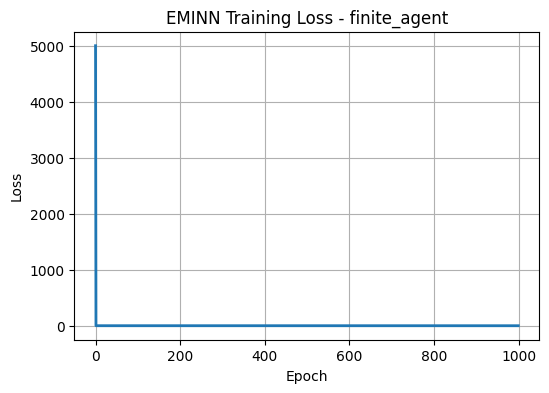

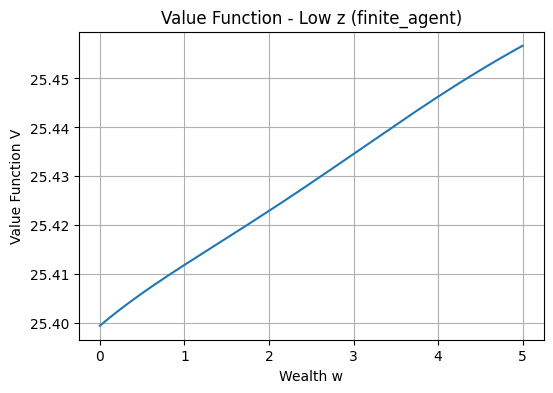

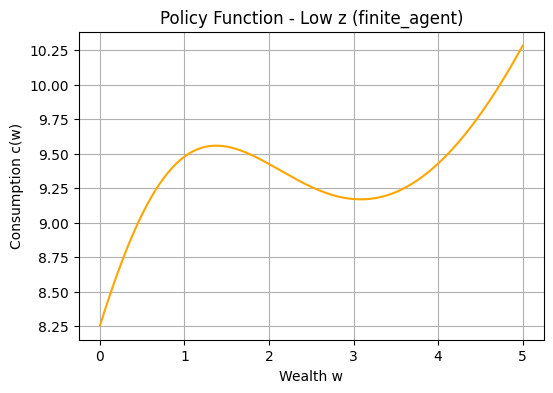

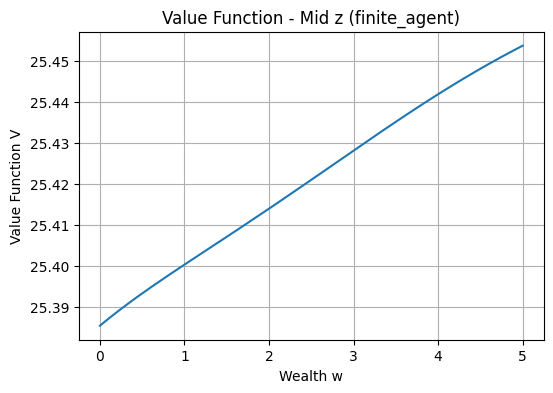

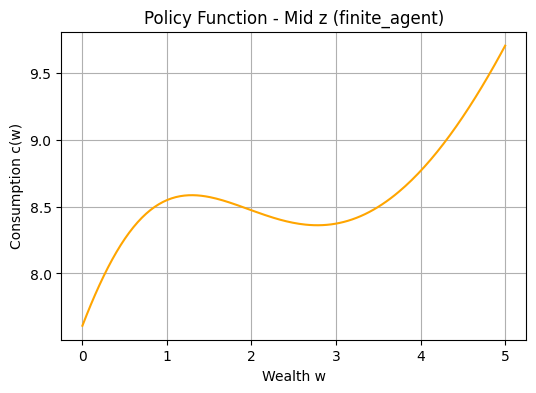

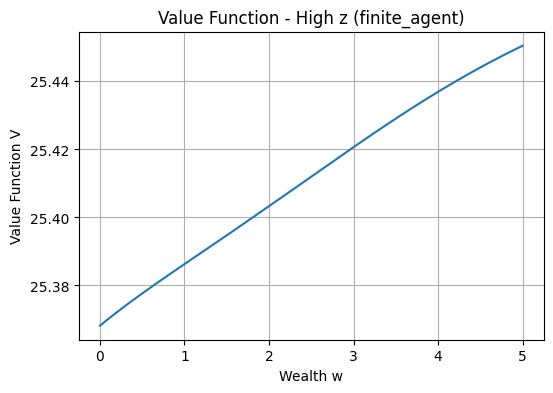

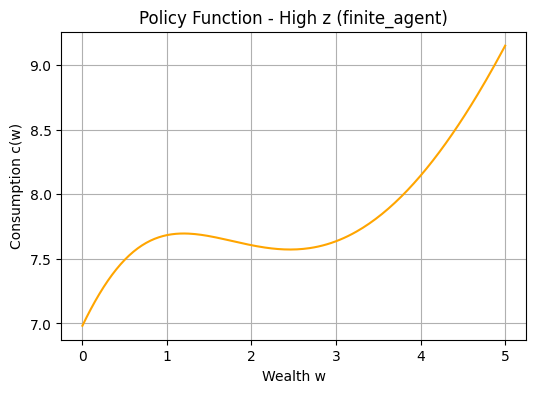

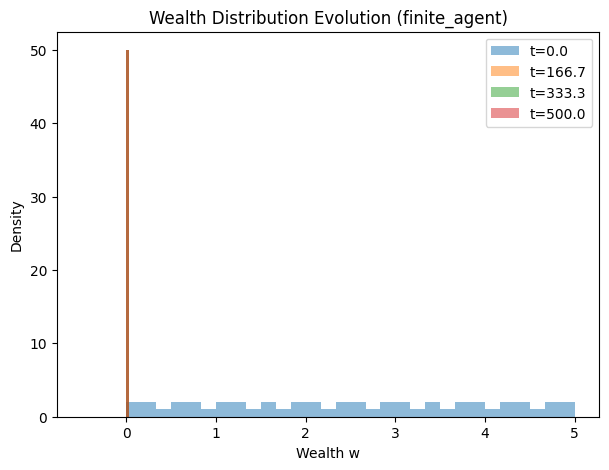

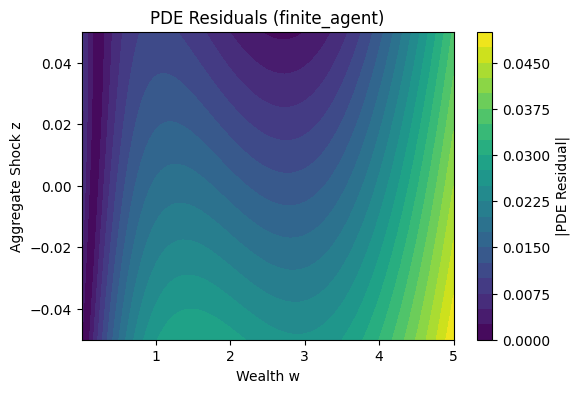

phi_path shape: (10000, 3)
phi_final: [0. 0. 0.]


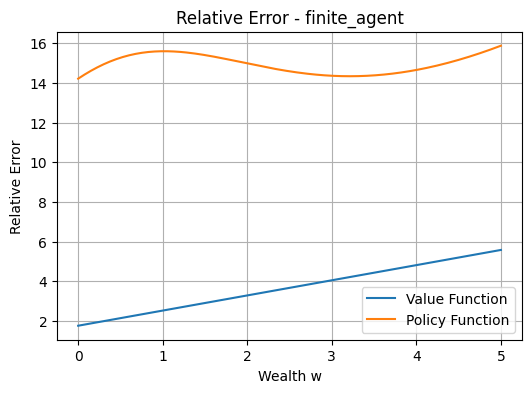

Error table saved at ./eminn_results/error_table_finite_agent.csv
Results for finite_agent:
          Method  Mean Residual  Std Residual  Max Residual  Mean Moment Error  \
0  finite_agent        0.01797      0.006754      0.035454          33.333333   

   Variance Moment Error  Skewness Moment Error  
0               0.001667                    0.0  

✅ Full EMINN pipeline completed for all methods!
Combined error table saved at: ./eminn_results/combined_error_table.csv
         Method  Mean Residual  Std Residual  Max Residual  Mean Moment Error  \
0  finite_agent        0.01797      0.006754      0.035454          33.333333   

   Variance Moment Error  Skewness Moment Error  
0               0.001667                    0.0  


In [57]:
if __name__ == "__main__":
    params = {
        'beta': 0.98, 'r': 0.03, 'wage': 1.0, 'rho': 0.95, 'sigma_z': 0.02,
        'z0': 0.0, 'w_min': 0.0, 'w_max': 5.0, 'sigma': 2.0, 'sigma_w': 0.01,
        'lambda_pen': 10.0
    }
    env = EconomicEnvironment(params)
    methods = ['finite_agent']
    error_dfs = []
    output_dir = "./eminn_results/"
    for method in methods:
        V_net = ValueNet(input_dim=1 + 1 + 3).to(device)
        print(f"Starting training using {method} method...")
        V_net, history = train_eminn(V_net, env, epochs=1000, batch_size=2048, lr=1e-3, method=method, verbose=True)
        plot_training_loss(history, output_dir=output_dir, method=method)
        policy_fn = get_policy_function(V_net, env)
        wealth_paths, z_path, phi_path = simulate_economy(env, policy_fn, method=method, T=100, dt=0.01)
        plot_value_and_policy(V_net, env, method=method, output_dir=output_dir)
        plot_wealth_distribution(wealth_paths, method=method, output_dir=output_dir)
        plot_pde_residuals(V_net, env, method=method, output_dir=output_dir)
        df_errors = generate_error_tables(V_net, env, method=method, output_dir=output_dir)
        error_dfs.append(df_errors)
        print(f"Results for {method}:\n", df_errors)
    combined_df = pd.concat(error_dfs, ignore_index=True)
    combined_df.to_csv(output_dir + "combined_error_table.csv", index=False)
    print(f"\n✅ Full EMINN pipeline completed for all methods!")
    print("Combined error table saved at:", output_dir + "combined_error_table.csv")
    print(combined_df)